In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Checking Metropolitan and EHMM samplers with linear Gaussian models

The experiments are for the models and samplers presented in the paper\
[1] Shestopaloff A.Y, Neal R.M. Sampling Latent States for High-Dimensional Non-Linear State Space Models with the Embedded HMM Method

---
## Model specification

We first consider a linear Gaussian state space model for an observed sequence $\mathbf{y}=(y_{1},...,y_{n})$. The model assumes that both observation density and density of unobserved Markov process $\mathbf{X}$ are Gaussian, specified by the following form:
$$\mathbf{x}_{t}=\mathbf{A}_{t}\mathbf{x}_{t-1}+\mathbf{\epsilon}_{t}$$
$$\mathbf{y}_{t}=\mathbf{C}_{t}\mathbf{x}_{t}+\mathbf{\delta}_{t}$$
where 
$$\mathbf{\epsilon}_{t}\sim N(0,\mathbf{Q}_{t})$$
$$\mathbf{\delta}_{t}\sim N(0,\mathbf{R}_{t})$$

We assume that the system is stationary, i.e., the parameters $\mathbf{\theta}_{t}=(\mathbf{A}_{t},\mathbf{C}_{t},\mathbf{Q}_{t},\mathbf{R}_{t})$ are independent of time. We will thus drop the subscript $t$ in the future references to these parameters.

### Transition model  
We define the transition Gaussian model as 
$$\mathbf{X}_{t}|x_{t-1}\sim N(\mathbf{A}x_{t-1}, \mathbf{Q}),t=1,...,T$$
with the state at time $t=0$ serving as a prior:
$\mathbf{X}_{0}\sim N(\mathbf{0},\mathbf{Q}_{init})$

We assume the state $\mathbf{X}$ is multidimensional of dimension $n$, with $\mathbf{X}_{t}=(X_{t,1},...,X_{t,n})'$ and set
$$\mathbf{A}=\begin{pmatrix}a_1 & 0 & \cdots & 0\\\ 0 & a_2 & \ddots & \vdots\\\ \vdots & \ddots & a_{n-1} & 0\\\ 0 & \cdots & 0 & a_n \end{pmatrix}$$

$$\mathbf{Q}=\begin{pmatrix}1 & \rho & \cdots & \rho\\\ \rho & 1 & \ddots & \vdots\\\ \vdots & \ddots & 1 & \rho\\\ \rho & \cdots & \rho & 1 \end{pmatrix}$$

$$\mathbf{Q}_{reset}=\begin{pmatrix}\frac{1}{1-a_{1}^{2}} & \frac{\rho}{\sqrt{1-a_{1}^{2}}\sqrt{1-a_{2}^{2}}} & \cdots & \frac{\rho}{\sqrt{1-a_{1}^{2}}\sqrt{1-a_{n}^{2}}}\\\ \frac{\rho}{\sqrt{1-a_{2}^{2}}\sqrt{1-a_{1}^{2}}} & \frac{1}{1-a_{2}^{2}} & \ddots & \vdots\\\ \vdots & \ddots & \frac{1}{1-a_{n-1}^{2}} & \frac{\rho}{\sqrt{1-a_{n-1}^{2}}\sqrt{1-a_{n}^{2}}}\\\ \frac{\rho}{\sqrt{1-a_{n}^{2}}\sqrt{1-a_{1}^{2}}} & \cdots & \frac{\rho}{\sqrt{1-a_{n}^{2}}\sqrt{1-a_{n-1}^{2}}} & \frac{1}{1-a_{n}^{2}} \end{pmatrix}$$

For the experiements below we use 10-dimensional latent state, with sequence length $T=250$. We set the parameter values as follows:\
$n=10, a_{i}=0.9\text{ for }i=1\ldots n,\text{ and }\rho=0.7$

In [39]:
# Set up the transition model with parameters above
T = 250
n = 10
A = DiagonalMatrixParam() 
A.value = np.eye(n) * 0.9
Q = SymmetricMatrixParam()
Q.value = np.ones((n,n)) * 0.7 + np.eye(n) * 0.3
prior_mean = np.zeros(n)
Q_init = Q.value * (1/(1-0.9*0.9))
trm = TransitionSpec(A, Q, prior_mean, Q_init)

### Observation model
The observation model is also a Gaussian defined as
$$\mathbf{Y}_{t}|x_{t}\sim N(\mathbf{C}x_{t}, \mathbf{R}),t=1,...,T$$

The dimension of the observation is the same as for the latent state. We assume each dimension is indpendent from the other with unit variance, and set the mean coefficients param $\mathbf{C}$ to:
$$\mathbf{C}=\begin{pmatrix}c_1 & 0 & \cdots & 0\\\ 0 & c_2 & \ddots & \vdots\\\ \vdots & \ddots & c_{n-1} & 0\\\ 0 & \cdots & 0 & c_n \end{pmatrix}$$
where $c_{i}=-0.4\text{ for }i=1\ldots n$

In [40]:
# Set up the observation model with parameters above
C = DiagonalMatrixParam()
C.value = np.eye(n) - 1.4 * np.eye(n)
R = DiagonalMatrixParam()
R.value = np.eye(n)
obsm = ObservationSpec(ModelType.LINEAR_GAUSS, C, R)

## Sampler specification  

We check the two sampling shcemes to sample from the distribution of the latent states: Metropolis single state update, and embedded EHMM method, described in [1]. As the resulting states distribution is Gaussian (as both transition and observation models are Gaussian) we can use a Kalman smoother to find exact solution and then compare it to the results produced by the samplers

### Metropolis sampling scheme
The scheme samples one state at a time, with all dimensions at once, conditional on all other states $x_{-t}=(x_{1},...,x_{t-1},x_{t+1},...,x_{n})$, using autoregressive update of the form described in [1].

In [41]:
# Specify metropolis scheme
met_sampler = SamplerSpec(SamplerType.METROPOLIS)

\
To run the simulation we need to provide the initial sample $\mathbf{x}_0$ to start off the sampler, and specify the parameters of the simulation. We set $\mathbf{x}_0=\mathbf{0}$ for this model and scheme. We run 5 simulations for $10^6$ iterations each, starting with the different seed for randomisation. To save memory we thin the sampling, only recording each tenth sample.

In [42]:
n_iter_met = int(1e3)
x_init = np.zeros((n, T))
seeds = np.array([1, 10, 100, 1e4, 1e5], dtype=int)  # <-- pass empty array, and add smoother spec to MCMC session, to run only Kalman smoother
scales_met = np.array([0.2, 0.8])
thinning = 10
simulation_met = SimulationSpec(n_iter_met, seeds, x_init, thinning, scales_met)

### Embedded HMM sampling scheme
This scheme was proposed in [1] and uses forward pool state selection. Each sampling step samples the whole sequence at once, using HMM forwards/backwards-like algorithm to select a state from the pool at each time. To generate the pool for each time the scheme uses autoregressive and shift updates. If specified it can alternate between updates on original and the reversed observations sequence. 

In [43]:
# Specify EHMM scheme
pool_sz = 50
ehmm_sampler = SamplerSpec(SamplerType.EHMM, pool_sz)

\
As with the single state sampler, we set $\mathbf{x}_0=\mathbf{0}$ for this model and scheme. We run 5 simulations for $10000$ iterations each, starting with the different seed for randomisation (we use the same seeds as for single state sampler). Each iteration will run on both original and reversed sequence of observations.

In [44]:
n_iter_ehmm = 10000
scales_ehmm = np.array([0.1, 0.4])
reverse = True
simulation_ehmm = SimulationSpec(n_iter_ehmm, seeds, x_init, scaling=scales_ehmm, reverse=reverse)

### Kalman smoother 
To check the validity of the samplers we also calculate the distribution of the latent states via Kalman smoother, which will give us the density $p(x_{t}|y_{1:T})\text{ at each time }t$. We will use information filter scheme to to find $p(x_{t}|y_{1:t})$ and then so-called "two-filter" scheme to find the smoothing distribution $p(x_{t}|y_{1:T})$. These results can then be comared with the results of the samplers to ensure they converge to the correct distribution.

In [45]:
kalman = SmootherSpec(FilterType.INFORMATION, SmootherType.TWOFILTER)

## Observations 
Finally, we need the observations, on which to run the samplers and the smoother. The data we use is the synthetic data, generated by the programme using the parameters of the models we specified. To control the output we provide teh seed for data generator.

In [46]:
dataspec = Data(seed=int(1e6))

## Simulation    
At first we run the Metropolitan single state sampler and compare the results with the Kalman smoother results. This will establish a benchmark for further experiments. We will also run the EHMM sampler and compre its results with our benchmark as well as with the single state sampler.

In [47]:
# Simulation with Metropolitan single state sampler
met_session_name = "met_gauss_noreverse_nonparm_v2"
mcmc_met_lg = MCMCsession(met_session_name)
if mcmc_met_lg.hasResults():
    mcmc_met_lg.loadResults() # <-- NB! Each file is ~2GB so it takes time to download
else:
    mcmc_met_lg.init(T, trm, obsm, met_sampler, simulation_met, dataspec, kalman)
    mcmc_met_lg.run()

Launched Baysis
Loaded model specifications.
111 = std::__1::function<std::__1::shared_ptr<algos::IMcmc> (HighFive::Group const&, HighFive::Group const&, HighFive::Group const&)>
112 = std::__1::function<std::__1::shared_ptr<algos::IMcmc> (HighFive::Group const&, HighFive::Group const&, HighFive::Group const&)>
121 = std::__1::function<std::__1::shared_ptr<algos::IMcmc> (HighFive::Group const&, HighFive::Group const&, HighFive::Group const&)>
122 = std::__1::function<std::__1::shared_ptr<algos::IMcmc> (HighFive::Group const&, HighFive::Group const&, HighFive::Group const&)>
131 = std::__1::function<std::__1::shared_ptr<algos::IMcmc> (HighFive::Group const&, HighFive::Group const&, HighFive::Group const&)>
132 = std::__1::function<std::__1::shared_ptr<algos::IMcmc> (HighFive::Group const&, HighFive::Group const&, HighFive::Group const&)>

Running Kalman smoother...	Done
Results saved into ../data/kalman_smoother_results.h5

Running sampler for met_gauss_noreverse_nonparm_v2 with 5 seeds

In [12]:
# Simulation with EHMM sampler
ehmm_session_name = "ehmm50_noflip_gauss_wreverse_nonparm"
mcmc_ehmm_lg = MCMCsession(ehmm_session_name)
if mcmc_ehmm_lg.hasResults():
    mcmc_ehmm_lg.loadResults()
else:
    mcmc_ehmm_lg.init(T, trm, obsm, ehmm_sampler, simulation_ehmm, dataspec)
    mcmc_ehmm_lg.run()

Launched Baysis
Loaded model specifications.
HighFive WARNING "reverse": data and hdf5 dataset have different types: Integer8 -> Enum8

Running sampler for ehmm50_noflip_gauss_wreverse_nonparm with 5 seeds:
	running with seed 1 ...
	Done in 926059ms
	results (and data used) saved into ../data/ehmm50_noflip_gauss_wreverse_nonparm_results_seed1.h5

	running with seed 10 ...
	Done in 926427ms
	results (and data used) saved into ../data/ehmm50_noflip_gauss_wreverse_nonparm_results_seed10.h5

	running with seed 100 ...
	Done in 915233ms
	results (and data used) saved into ../data/ehmm50_noflip_gauss_wreverse_nonparm_results_seed100.h5

	running with seed 10000 ...
	Done in 927073ms
	results (and data used) saved into ../data/ehmm50_noflip_gauss_wreverse_nonparm_results_seed10000.h5

	running with seed 100000 ...
	Done in 913602ms
	results (and data used) saved into ../data/ehmm50_noflip_gauss_wreverse_nonparm_results_seed100000.h5

######### All done #########
Loading results for seed10000.

---
## Analysis of the results

In [13]:
smoother_results = SmootherResults()

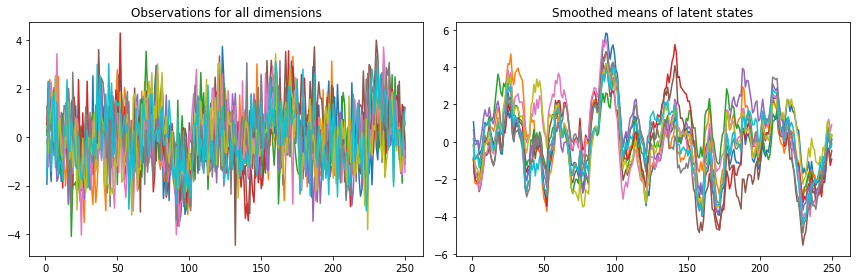

In [14]:
# Plot the observations for all dimenstions across time vs the means of the latent states from Kalman smoother
fig, ax = plt.subplots(1, 2, figsize=(12,4))
xs = np.array(range(1, T+1))
for i in range(n):
    ax[0].plot(xs, mcmc_met_lg.data[:,i])
    ax[1].plot(xs, smoother_results.means[:,i])
ax[0].set_title("Observations for all dimensions")
ax[1].set_title("Smoothed means of latent states")
plt.tight_layout()
plt.show();
# TODO:
# - make lines lighter 
# - highlight the same dimension with the same colour 
# - make possible to highilght some dimensions and dim others 

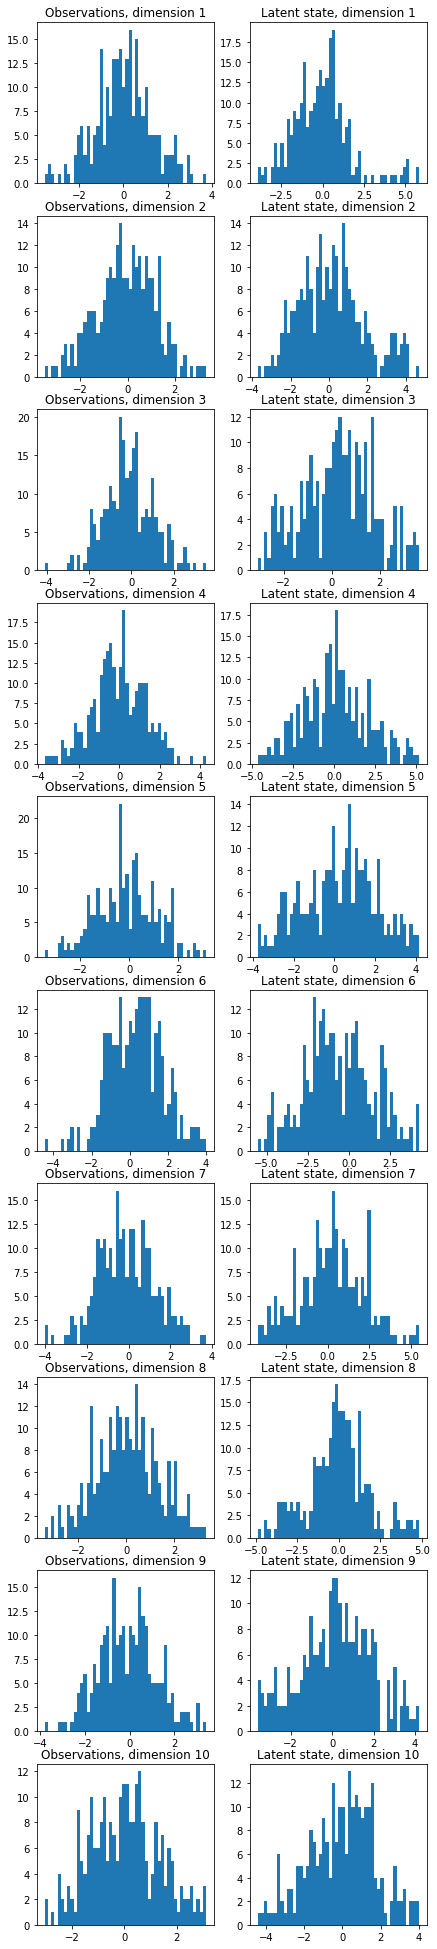

In [15]:
# Let's look at histograms of the data and the latent states means
fig, ax = plt.subplots(10, 2, figsize=(7,35))
for i in range(n):
    ax[i,0].hist(mcmc_met_lg.data[:,i], bins=50)
    ax[i,0].set_title(f"Observations, dimension {i+1}")
    ax[i,1].hist(smoother_results.means[:,i], bins=50)
    ax[i,1].set_title(f"Latent state, dimension {i+1}")
plt.show();
# TODO:
# - make y & x-axis the same range for all plots

In [16]:
# Compare the smoothed means with average means from 5 runs of metropolis sampler
samples_means = {}
all_seeds_means = np.zeros((T, n))
burnin = int(0.1 * (n_iter_met/thinning + 1))

for seed, sample in mcmc_met_lg.samples.items():
    samples_means[seed] = np.mean(sample[burnin:], axis=0)
    all_seeds_means += samples_means[seed]

all_seeds_means /= seeds.size

In [17]:
met_means = pd.DataFrame({f"seed{seed}":samples_means[f'seed{seed}'][-1] for seed in seeds})\
            .join(pd.DataFrame({"total_mean": all_seeds_means[-1], "kalman":smoother_results.means[-1]}))
met_means["diff"] = abs(np.log(abs(met_means["total_mean"])) - np.log(abs(met_means["kalman"])))
met_means
# TODO:
# - add scatterplot between Kalman means and sampled means

,seed1,seed10,seed100,seed10000,seed100000,total_mean,kalman,diff
0,0.171946,0.135651,0.144179,0.156319,0.146671,0.150953,0.152385,0.009441
1,0.398859,0.391352,0.382522,0.380663,0.399290,0.390537,0.390795,0.000659
2,0.317442,0.337317,0.315891,0.326558,0.323752,0.324192,0.319107,0.015810
3,-0.954524,-0.927333,-0.924384,-0.921515,-0.940027,-0.933557,-0.933533,0.000025
4,0.118377,0.111662,0.114021,0.101158,0.119895,0.113023,0.115583,0.022400
5,-0.494061,-0.485282,-0.480260,-0.482604,-0.472106,-0.482863,-0.477413,0.011351
6,0.933754,0.914361,0.924740,0.903940,0.936521,0.922663,0.923921,0.001363
7,-0.074376,-0.077329,-0.087154,-0.078576,-0.088708,-0.081229,-0.078499,0.034185
8,0.343420,0.345364,0.341275,0.348957,0.326903,0.341184,0.337072,0.012124
9,-0.172551,-0.190016,-0.173521,-0.172782,-0.149701,-0.171714,-0.182339,0.060037


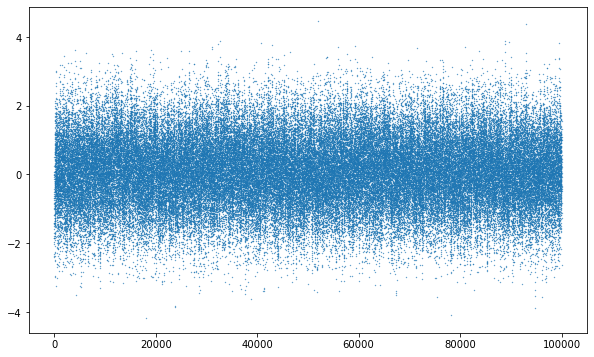

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
xs = np.array(range(int(n_iter_met/thinning + 1)))+1
ax.scatter(xs, mcmc_met_lg.samples['seed100'][:,1,0], s=0.1)
plt.show();

In [19]:
# Compare the smoothed means with average means from 5 runs of EHMM sampler
ehm_samples_means = {}
ehm_all_seeds_means = np.zeros((T, n))
ehm_burnin = int(0.1 * 2 * (n_iter_ehmm + 1)) # <-- as we run on reversed sequence, too, there will be twice as many samples

for seed, sample in mcmc_ehmm_lg.samples.items():
    ehm_samples_means[seed] = np.mean(sample[ehm_burnin:], axis=0)
    ehm_all_seeds_means += ehm_samples_means[seed]

ehm_all_seeds_means /= seeds.size

In [20]:
ehm_means = pd.DataFrame({f"seed{seed}":ehm_samples_means[f'seed{seed}'][-1] for seed in seeds})\
            .join(pd.DataFrame({"total_mean": ehm_all_seeds_means[-1], "kalman":smoother_results.means[-1]}))
ehm_means["diff"] = abs(np.log(abs(ehm_means["total_mean"])) - np.log(abs(ehm_means["kalman"])))
ehm_means

,seed1,seed10,seed100,seed10000,seed100000,total_mean,kalman,diff
0,0.177680,0.124188,0.149665,0.127494,0.147169,0.145239,0.152385,0.048030
1,0.371460,0.390293,0.384515,0.395230,0.402346,0.388769,0.390795,0.005198
2,0.307927,0.348749,0.311227,0.317458,0.311065,0.319285,0.319107,0.000559
3,-0.942519,-0.930226,-0.929397,-0.916905,-0.962855,-0.936380,-0.933533,0.003045
4,0.110982,0.144388,0.139852,0.129434,0.103404,0.125612,0.115583,0.083210
5,-0.485671,-0.482531,-0.465232,-0.432615,-0.483386,-0.469887,-0.477413,0.015889
6,0.943105,0.924004,0.939866,0.923208,0.913302,0.928697,0.923921,0.005156
7,-0.082557,-0.086246,-0.094786,-0.065471,-0.049550,-0.075722,-0.078499,0.036016
8,0.343600,0.347862,0.379111,0.325087,0.332511,0.345634,0.337072,0.025083
9,-0.215082,-0.157050,-0.148361,-0.194599,-0.178555,-0.178729,-0.182339,0.019996


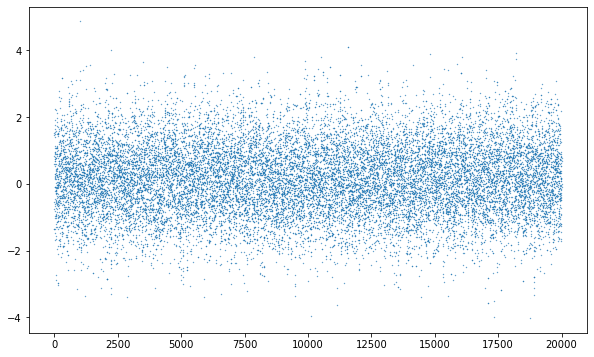

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
ehm_xs = np.array(range(2*(n_iter_ehmm + 1)))+1
ax.scatter(ehm_xs, mcmc_ehmm_lg.samples['seed100'][:,249,0], s=0.1)
plt.show();